In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.cluster.vq import *
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics

import os

In [2]:
def watershed(img):
    # convert image color to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # threshold segmentation
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknow = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknow==255] = 0
    markers = cv2.watershed(img, markers)

    # mark the boundary
    img[markers == -1] = [0, 255, 0]

    return img

In [3]:
''' Read images required and do preprocessing '''
def read_image(plant_name, keyword):

    def endWith(s,*endstring):
        array = map(s.endswith,endstring)
        if True in array:
            return True
        else:
            return False

    # create binary label for plants, 0 - Ara, 1 - Tobacco
    if plant_name == "Ara2013-Canon":
        label = 0
    else:
        label = 1

    images, labels = [], []
    folder_path = 'Plant_Phenotyping_Datasets/Plant_Phenotyping_Datasets/Plant/' + plant_name + '/'

    # go through images directory
    file_list = os.listdir(folder_path)
    for file in file_list:
        if endWith(file, keyword):
            img_path = folder_path + file

            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # resize images to same scale
            img_scale = cv2.resize(img_rgb, (255, 255), interpolation=cv2.INTER_AREA)
            
            # Median filter
            img_filter = cv2.medianBlur(img_scale, 5)

            # Sharpening
            sharpening_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
            img_sharpen = cv2.filter2D(img_filter, -1, sharpening_filter)

            img_res = watershed(img_sharpen)
            images.append(img_res)
            labels.append(label)
    return images, labels

In [4]:
Ara_images, Ara_labels = read_image(plant_name="Ara2013-Canon", keyword="_rgb.png")
Tobacco_images, Tobacco_labels = read_image(plant_name="Tobacco", keyword="_rgb.png")
print(len(Ara_images), len(Ara_labels))
print(len(Tobacco_images), len(Tobacco_labels))

165 165
62 62


In [5]:
data = Ara_images + Tobacco_images
target = Ara_labels + Tobacco_labels

# split the data set and label set
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25)

In [6]:
# using SURF to obtain key points and fetaures
train_des = []
surf = cv2.xfeatures2d.SURF_create(800)
for img in x_train:
    kp, des = surf.detectAndCompute(img, None)
    train_des.append(des)
print(len(train_des))  # (64, ,170)

170


In [7]:
# concat features of images together
train_features = []
for des in train_des:
    for feature in des:
        train_features.append(feature)
print(len(train_features))

17462


In [8]:
k = 100
codebook, _ = kmeans(train_features, k, 1)  
print(len(codebook[0]))# (64, 100)

64


In [9]:
# Feature Histogram
hg = np.zeros((len(train_des), k), 'float32')
for i in range(len(train_des)):
    code, dist = vq(train_des[i], codebook)
    for can in code:
        hg[i][can] += 1
print(hg)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 2. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 3. 0.]]


In [10]:
# create model
# svm_model = svm.LinearSVC()
# svm_model.fit(hg, y_train)
# print(hg.shape, len(y_train))

In [11]:
rf_model = RandomForestClassifier(max_depth=11, random_state=0, n_estimators=41)
rf_model.fit(hg, y_train)

RandomForestClassifier(max_depth=11, n_estimators=41, random_state=0)

In [12]:
# ada_model = AdaBoostClassifier()
# ada_model.fit(hg, y_train)

In [13]:
# using SURF to obtain key points and fetaures
test_des = []
surf = cv2.xfeatures2d.SURF_create(800)
for img in x_test:
    kp, des = surf.detectAndCompute(img, None)
    test_des.append(des)
print(len(test_des))

57


In [14]:
# concat features of images together
test_features = []
for des in test_des:
    for feature in des:
        test_features.append(feature)
print(len(test_features))

5558


In [15]:
# Feature Histogram
test_hg = np.zeros((len(test_des), k), 'float32')
for i in range(len(test_des)):
    code, dist = vq(test_des[i], codebook)
    for can in code:
        test_hg[i][can] += 1
print(test_hg)

[[ 0.  0.  3. ...  0.  1.  0.]
 [ 2. 12. 11. ...  1.  9.  1.]
 [ 0.  2.  0. ...  2.  0.  1.]
 ...
 [ 0.  0.  0. ...  0.  1.  1.]
 [ 1.  0.  3. ...  0.  0.  1.]
 [ 2.  0.  0. ...  0.  1.  2.]]


In [16]:
# svm_prediction = svm_model.predict(test_hg)
# pre = metrics.accuracy_score(y_test, svm_prediction)
# rec = metrics.recall_score(y_test, svm_prediction)
# auc = metrics.roc_auc_score(y_test, svm_prediction)
# print("SVM:")
# print("roc_auc:", auc)
# print("precision:", pre)
# print("recall:", rec)

In [17]:
print("Random Forest:")
rf_prediction = rf_model.predict(test_hg)
pre = metrics.accuracy_score(y_test, rf_prediction)
rec = metrics.recall_score(y_test, rf_prediction)
auc = metrics.roc_auc_score(y_test, rf_prediction)
print("roc_auc:", auc)
print("precision:", pre)
print("recall:", rec)

Random Forest:
roc_auc: 0.9642857142857143
precision: 0.9824561403508771
recall: 0.9285714285714286


In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_prediction, pos_label=1)
print(tpr, fpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)


[0.         0.92857143 1.        ] [0. 0. 1.] [2 1 0]


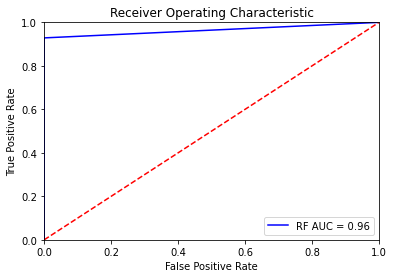

In [19]:
# plot the auc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'RF AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
# print("Ada Boost:")
# ada_prediction = ada_model.predict(test_hg)
# pre = metrics.accuracy_score(y_test, ada_prediction)
# rec = metrics.recall_score(y_test, ada_prediction)
# auc = metrics.roc_auc_score(y_test, ada_prediction)
# print("roc_auc:", auc)
# print("precision:", pre)
# print("recall:", rec)